In [28]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import os
import sys
import json
from pprint import pprint
import collections
import pickle

import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from matplotlib.lines import Line2D
from matplotlib import colors
from matplotlib import cm as CM

import numpy as np
import ipywidgets as widgets
from matplotlib import gridspec
from scipy.stats import gaussian_kde
from scipy import stats
import tensorflow as tf
from scipy.signal import firwin

project_root = '..'
sys.path.append(project_root)

from sleeprnn.nn.spectrum import compute_wavelets, apply_wavelets_rectangular, compute_wavelets_noisy
from sleeprnn.helpers import reader, plotter, printer, misc, performer
from sleeprnn.data import utils, stamp_correction
from sleeprnn.detection.feeder_dataset import FeederDataset
from sleeprnn.detection import metrics
from sleeprnn.detection.postprocessor import PostProcessor
from sleeprnn.common import constants, pkeys, viz
from sleeprnn.common.optimal_thresholds import OPTIMAL_THR_FOR_CKPT_DICT

import ipywidgets as widgets
import matplotlib.pyplot as plt
from matplotlib import colors, gridspec
import numpy as np
from scipy.stats import gaussian_kde
from scipy.interpolate import interp1d

project_root = '..'
sys.path.append(project_root)

RESULTS_PATH = os.path.join(project_root, 'results')
COMPARISON_PATH = os.path.join(project_root, 'resources', 'comparison_data')
viz.notebook_full_width()

%matplotlib inline

In [3]:
general_lw = 1.0
signal_lw = 0.8
general_color = viz.GREY_COLORS[9]
signal_color = viz.GREY_COLORS[7]
custom_color = viz.PALETTE['blue'] # viz.PALETTE['cyan'] # viz.PALETTE['blue']
ss_color = viz.PALETTE['blue']
kc_color = viz.PALETTE['green']
pred_color = viz.PALETTE['red']

In [4]:
subject_id = 1
which_kc_stamp = 195
left_context = 10#-2#4
right_context = 10#12#6

dataset = reader.load_dataset(constants.MASS_SS_NAME)
signal = dataset.get_subject_signal(subject_id=subject_id, normalize_clip=False)
stamps_ss = dataset.get_subject_stamps(subject_id=subject_id)
dataset = reader.load_dataset(constants.MASS_KC_NAME)
stamps_kc = dataset.get_subject_stamps(subject_id=subject_id)
fs = dataset.fs

print('%d SS stamps.' % stamps_ss.shape[0])
print('%d KC stamps.' % stamps_kc.shape[0])

segment_size = left_context + right_context
central_sample = stamps_kc[which_kc_stamp, :].mean()
start_sample = int(central_sample - fs * left_context)
end_sample = int(central_sample + fs * right_context)

segment_stamps_ss = utils.filter_stamps(stamps_ss, start_sample, end_sample)
segment_stamps_kc = utils.filter_stamps(stamps_kc, start_sample, end_sample)
segment_signal = signal[start_sample:end_sample]
time_axis = np.arange(start_sample, end_sample) / fs

Train size: 11. Test size: 4
Train subjects: 
 [1, 3, 5, 7, 9, 10, 11, 14, 17, 18, 19]
Test subjects: 
 [2, 6, 12, 13]
Dataset mass_ss with 15 patients.
Loading from checkpoint... Loaded
Global STD: 16.482042
Mean FFT Scaling of non-testing set: 1.5594099147386842
Per subject FFT scaling / Mean:
S01: 1.0215
S02: 1.0696
S03: 1.0474
S05: 1.0631
S06: 0.9940
S07: 0.9877
S09: 0.9348
S10: 0.8341
S11: 1.0459
S12: 0.7592
S13: 1.0895
S14: 0.9727
S17: 0.9233
S18: 0.9265
S19: 1.2431
Using Custom Scaling Dict
S01: 1.0000
S02: 1.0000
S03: 1.0000
S05: 1.0000
S06: 1.0000
S07: 1.0000
S09: 1.0000
S10: 1.0000
S11: 1.0000
S12: 1.0000
S13: 1.0000
S14: 1.0000
S17: 1.0000
S18: 1.0000
S19: 1.0000
Train size: 11. Test size: 4
Train subjects: 
 [1, 3, 5, 7, 9, 10, 11, 14, 17, 18, 19]
Test subjects: 
 [2, 6, 12, 13]
Dataset mass_kc with 15 patients.
Loading from checkpoint... Loaded
Global STD: 16.482042
1044 SS stamps.
409 KC stamps.


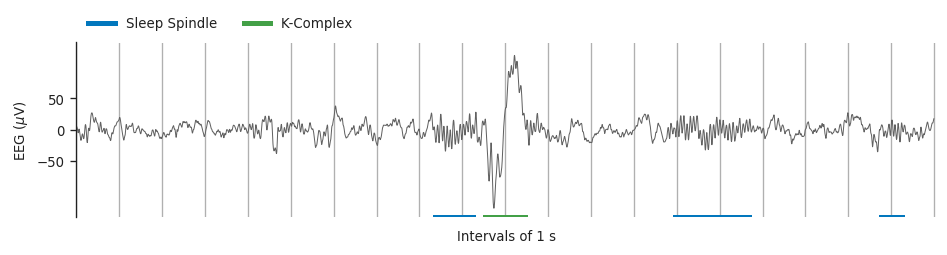

In [5]:
dpi = 120
y_max = 140
y_min = -140
figsize = (8, 2)
alpha = 1
linewidth_mark = 3
ss_correction_right = -0.1

fig, ax = plt.subplots(1, 1, dpi=dpi, figsize=figsize)

ax.plot(time_axis, segment_signal, linewidth=0.6, color=signal_color)
stamp_label_used = False
for stamp in segment_stamps_ss:
    if stamp_label_used:
        label = None
    else:
        label = 'Sleep Spindle'
        stamp_label_used = True
    ax.plot(
        [stamp[0] / fs, stamp[1] / fs + ss_correction_right], [y_min, y_min], label=label, 
        color=ss_color, linewidth=linewidth_mark)
    # ax.fill_between(
    #     stamp / fs, y_mark, -y_mark, 
    #     facecolor=ss_color, alpha=alpha, label=label)
stamp_label_used = False
for stamp in segment_stamps_kc:
    if stamp_label_used:
        label = None
    else:
        label = 'K-Complex'
        stamp_label_used = True
    ax.plot(
        stamp / fs, [y_min, y_min], label=label, 
        color=kc_color, linewidth=linewidth_mark)
    # ax.fill_between(
    #     stamp / fs, y_mark, -y_mark, 
    #     facecolor=kc_color, alpha=alpha, label=label)
ax.set_xlabel('Intervals of 1 s', fontsize=viz.FONTSIZE_GENERAL)
ax.set_ylabel('EEG ($\mu$V)', fontsize=viz.FONTSIZE_GENERAL)
ax.set_yticks([-50, 0, 50])
ax.set_xlim([time_axis[0], time_axis[-1]+0.05])
ax.set_ylim([y_min, y_max])
ax.set_xticks([])
ax.set_xticks(np.arange(time_axis[0], time_axis[-1]+0.1, 1), minor=True)
ax.grid(b=True, axis='x', which='minor')
lg = ax.legend(loc='lower left', bbox_to_anchor=(0,1), ncol=2, fontsize=viz.FONTSIZE_GENERAL, frameon=False)
ax.tick_params(labelsize=viz.FONTSIZE_GENERAL)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['bottom'].set_visible(False)
# ax.spines['left'].set_visible(False)
ax.tick_params(axis='x', which='both',length=0)
for lh in lg.legendHandles:
    lh.set_alpha(min(2 * alpha, 1.0))

# Change color of plot
plt.setp(lg.get_texts(), color=general_color)
ax = plotter.set_axis_color(ax, general_color)
plt.tight_layout()

# plt.savefig("ss_kc_example.eps")

plt.show()

# Alpha intrusion

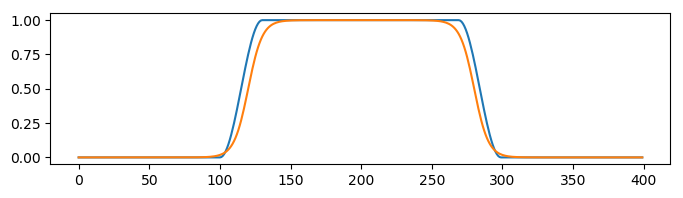

In [110]:
n_samples = 200
start_sample = 100
end_sample = start_sample  + n_samples
page_size = 400

window = np.zeros(page_size)
window[start_sample:end_sample] = custom_window(n_samples)

# sigmoid style
def sigmoid(x, offset, scaling):
    return 1 / (np.exp((-x + offset) / scaling) + 1)

k_array = np.arange(page_size)
offset_1 = start_sample + 0.1 * n_samples
scaling_1 = 0.1 * n_samples / 4
window_v2 = sigmoid(k_array, offset_1, scaling_1)
offset_2 = start_sample + 0.9 * n_samples
scaling_2 = 0.1 * n_samples / 4
window_v2 -= sigmoid(k_array, offset_2, scaling_2)

fig, ax = plt.subplots(1,1, dpi=100, figsize=(8, 2))
ax.plot(window)
ax.plot(window_v2)
plt.show()

In [111]:
def sigmoid(x):
    return 1 / (np.exp(-x) + 1)


def custom_window_v2(total_width, window_start, window_width):
    k_array = np.arange(total_width)
    offset_1 = window_start + 0.1 * window_width
    offset_2 = window_start + 0.9 * window_width
    scaling = 0.1 * window_width / 4
    window = sigmoid((k_array - offset_1) / scaling) - sigmoid((k_array - offset_2) / scaling)
    return window


def custom_window(n_samples):
    reduced_samples = 2 * int(n_samples * 0.3 / 2) + 1
    half_size = reduced_samples // 2
    window_reduced = np.hanning(reduced_samples)    
    window = np.ones(n_samples)
    window[:half_size] = window_reduced[:half_size]
    window[-half_size:] = window_reduced[-half_size:]
    return window


def smooth_noise(page_size, lp_filter_size):
    # Define Low-Pass filter
    lp_filter = np.hanning(lp_filter_size)
    lp_filter /= lp_filter.sum()
    # Sample uniform noise [0,1] and transform to [-1,1] range
    noise_vector = (2 * np.random.rand(page_size) - 1)
    # LP filter the noise to smooth it
    noise_vector = np.convolve(noise_vector, lp_filter, mode="same")
    # Set noise to [0, 1] range
    min_val = noise_vector.min()
    max_val = noise_vector.max()
    noise_vector = (noise_vector - min_val) / (max_val - min_val)
    return noise_vector


def generate_alpha_intrusion(
    page_size, fs,
    alpha_max_amplitude,  # same units as signal (absolute)
    alpha_min_duration=1,  # [s]
    alpha_max_duration=5,  # [s]
    alpha_min_freq=8,  # [Hz]
    alpha_max_freq=11,  # [Hz]
    alpha_max_noise_freq=2,  # [Hz]
    alpha_freq_filter_duration=0.5,  # [s] 
    alpha_amp_filter_duration=0.5  # [s]
):
    alpha_min_size = int(fs * alpha_min_duration)
    alpha_max_size = int(fs * alpha_max_duration)
    alpha_freq_filter_size = int(fs * alpha_freq_filter_duration)
    alpha_amp_filter_size = int(fs * alpha_amp_filter_duration)
    time_template = np.arange(page_size) / fs
    # Window
    duration = np.random.uniform(alpha_min_duration, alpha_max_duration)
    wave_size = int(fs * duration)
    start_sample = int(np.random.uniform(1, page_size - wave_size - 1))
    # end_sample = start_sample + wave_size
    window = custom_window_v2(page_size, start_sample, wave_size)
    #window = np.zeros(page_size)
    #window[start_sample:end_sample] = custom_window(wave_size)
    # Oscillation 
    central_freq = np.random.uniform(alpha_min_freq, alpha_max_freq)
    noise_freq = smooth_noise(page_size, alpha_freq_filter_size)
    wave_freq = central_freq + alpha_max_noise_freq * (2 * noise_freq - 1)
    wave_phase = 2 * np.pi * np.cumsum(wave_freq) / fs
    oscillation = np.cos(wave_phase)
    # Amplitude
    amplitude_high = np.random.uniform(0, alpha_max_amplitude)
    amplitude_low = np.random.uniform(0, amplitude_high)
    amplitude_noise = smooth_noise(page_size, alpha_amp_filter_size)
    amplitude = amplitude_low + amplitude_noise * (amplitude_high - amplitude_low)
    # Total wave
    alpha_wave = window * amplitude * oscillation
    return alpha_wave


def lowpass(signal, fs, cutoff, numtaps):
    lp_fir = firwin(numtaps, cutoff=cutoff, window="hamming", fs=fs)
    samples_removed = numtaps // 2
    signal_padded = np.concatenate([np.zeros(samples_removed), signal, np.zeros(samples_removed)])
    new_signal = np.convolve(signal_padded, lp_fir, mode="valid")
    return new_signal


def highpass(signal, fs, cutoff, numtaps):
    # ensure odd numtaps
    numtaps = int(2 * (numtaps // 2) + 1)
    central_fir_sample = numtaps//2
    lp_fir = firwin(numtaps, cutoff=cutoff, window="hamming", fs=fs)
    # HP = delta - LP
    hp_fir = -lp_fir
    hp_fir[central_fir_sample] += 1
    samples_removed = numtaps // 2
    signal_padded = np.concatenate([np.zeros(samples_removed), signal, np.zeros(samples_removed)])
    new_signal = np.convolve(signal_padded, hp_fir, mode="valid")
    return new_signal

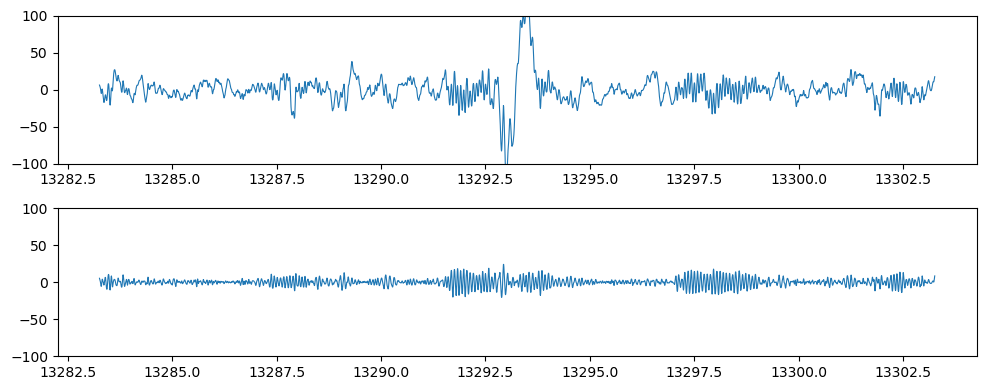

In [112]:
# Design HP-filter with cutoff frequency at 4 Hz
#hp_signal = segment_signal - lowpass(segment_signal, fs, cutoff=4, numtaps=751)
hp_signal = highpass(segment_signal, fs, cutoff=8, numtaps=375)

fig, ax = plt.subplots(2,1,figsize=(10, 4), dpi=100)
ax[0].plot(time_axis, segment_signal, linewidth=0.8)
ax[1].plot(time_axis, hp_signal, linewidth=0.8)
ax[0].set_ylim([-100, 100])
ax[1].set_ylim([-100, 100])
plt.tight_layout()
plt.show()

STD 5.349549314679775 MAX 23.984641438915116


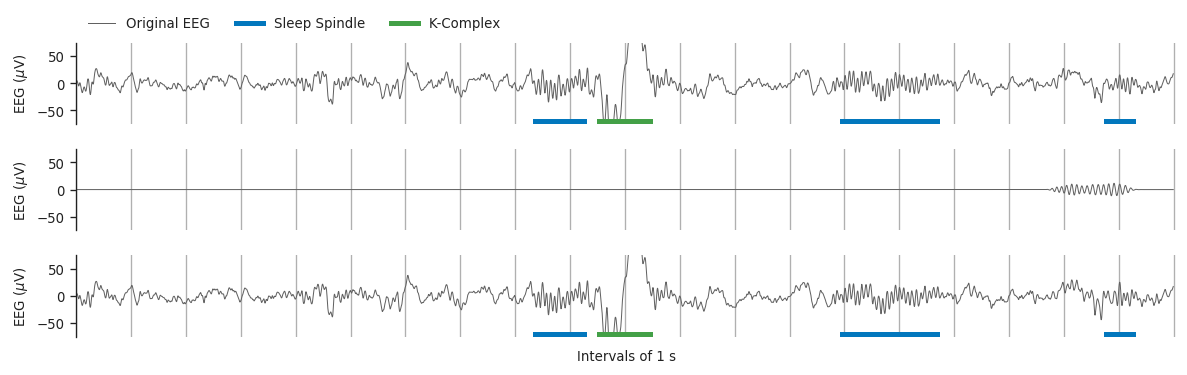

In [118]:
hp_signal = highpass(segment_signal, fs, cutoff=8, numtaps=375)  # 8-35 Hz in practice
print("STD", hp_signal.std(), "MAX", hp_signal.max())
alpha_max_amplitude = 0.7 * hp_signal.max()  # same units as signal (absolute)
alpha_wave = generate_alpha_intrusion(dataset.page_size, fs, alpha_max_amplitude=alpha_max_amplitude)
new_signal = segment_signal + alpha_wave

fig, axes = plt.subplots(3, 1, dpi=120, figsize=(10, 3))
for ax_num, ax, this_signal, name in zip(
    range(3), axes, [segment_signal, alpha_wave, new_signal], ["Original EEG", "Synthetic Alpha Wave", "Modified EEG"]):
    ax.plot(time_axis, this_signal, linewidth=0.6, color=signal_color, label=name)
    stamp_label_used = False
    if ax_num != 1:
        for stamp in segment_stamps_ss:
            if stamp_label_used:
                label = None
            else:
                label = 'Sleep Spindle'
                stamp_label_used = True
            ax.plot(
                [stamp[0] / fs, stamp[1] / fs + ss_correction_right], [-70, -70], label=label, 
                color=ss_color, linewidth=linewidth_mark)
        stamp_label_used = False
        for stamp in segment_stamps_kc:
            if stamp_label_used:
                label = None
            else:
                label = 'K-Complex'
                stamp_label_used = True
            ax.plot(
                stamp / fs, [-70, -70], label=label, 
                color=kc_color, linewidth=linewidth_mark)
    ax.set_ylabel('EEG ($\mu$V)', fontsize=viz.FONTSIZE_GENERAL)
    ax.set_yticks([-50, 0, 50])
    ax.set_xlim([time_axis[0], time_axis[-1]+0.05])
    ax.set_ylim([-75, 75])
    ax.set_xticks([])
    ax.set_xticks(np.arange(time_axis[0], time_axis[-1]+0.1, 1), minor=True)
    ax.grid(b=True, axis='x', which='minor')
    ax.tick_params(labelsize=viz.FONTSIZE_GENERAL)
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.tick_params(axis='x', which='both',length=0)
    if ax_num == 0:
        lg = ax.legend(loc='lower left', bbox_to_anchor=(0,1), ncol=3, fontsize=viz.FONTSIZE_GENERAL, frameon=False)
        for lh in lg.legendHandles:
            lh.set_alpha(min(2 * alpha, 1.0))
        # Change color of plot
        plt.setp(lg.get_texts(), color=general_color)
    ax = plotter.set_axis_color(ax, general_color)
axes[-1].set_xlabel('Intervals of 1 s', fontsize=viz.FONTSIZE_GENERAL)
plt.tight_layout()
plt.show()

# Alpha Intrusion TF

In [127]:
def custom_window_tf(total_width, window_start, window_width):
    # Only total width is required to be integer
    k_array = np.arange(total_width)  # page size should be constant once defined during training
    offset_1 = window_start + 0.1 * window_width
    offset_2 = window_start + 0.9 * window_width
    scaling = 0.1 * window_width / 4
    window = tf.math.sigmoid((k_array - offset_1) / scaling) - tf.math.sigmoid((k_array - offset_2) / scaling)
    return window

def smooth_noise_tf(page_size, lp_filter_size, name):
    # Define Low-Pass filter
    # This filter is defined online once so it's okay to be numpy
    lp_filter = np.hanning(lp_filter_size)
    lp_filter /= lp_filter.sum()  
    lp_filter = lp_filter.astype(np.float32)
    # Reshape kernel [kernel_size] -> [1, kernel_size, 1, 1]
    lp_filter = np.reshape(lp_filter, newshape=(1, -1, 1, 1))
    with tf.variable_scope(name):
        # Sample uniform noise [0,1] and transform to [-1,1] range
        noise_vector = tf.random.uniform([page_size], minval=-1, maxval=1)
        # LP filter the noise to smooth it
        # Reshape input [time_len] -> [1, 1, time_len, 1]
        noise_vector_expand = tf.expand_dims(noise_vector, axis=0)
        noise_vector_expand = tf.expand_dims(noise_vector_expand, axis=1)
        noise_vector_expand = tf.expand_dims(noise_vector_expand, axis=3)
        noise_vector = tf.nn.conv2d(
            input=noise_vector_expand, filter=lp_filter, strides=[1, 1, 1, 1], padding="SAME")
        # Remove extra dim
        noise_vector = tf.squeeze(noise_vector, axis=3, name="squeeze")
        noise_vector = tf.squeeze(noise_vector, axis=1, name="squeeze")
        noise_vector = tf.squeeze(noise_vector, axis=0, name="squeeze")
        # Set noise to [0, 1] range
        min_val = tf.reduce_min(noise_vector)
        max_val = tf.reduce_max(noise_vector)
        noise_vector = (noise_vector - min_val) / (max_val - min_val)
    return noise_vector


def generate_alpha_intrusion_tf(
    page_size, fs,
    alpha_max_amplitude,  # same units as signal (absolute)
    alpha_min_duration=1,  # [s]
    alpha_max_duration=5,  # [s]
    alpha_min_freq=8,  # [Hz]
    alpha_max_freq=11,  # [Hz]
    alpha_max_noise_freq=2,  # [Hz]
    alpha_freq_filter_duration=0.5,  # [s] 
    alpha_amp_filter_duration=0.5  # [s]
):
    # This is ok to be numpy
    alpha_min_size = int(fs * alpha_min_duration)
    alpha_max_size = int(fs * alpha_max_duration)
    alpha_freq_filter_size = int(fs * alpha_freq_filter_duration)
    alpha_amp_filter_size = int(fs * alpha_amp_filter_duration)
    time_template = np.arange(page_size) / fs
    # Window
    duration = tf.random.uniform([], minval=alpha_min_duration, maxval=alpha_max_duration)
    wave_size = fs * duration
    start_sample = tf.random.uniform([], minval=1, maxval=(page_size - wave_size - 1))
    window = custom_window_tf(page_size, start_sample, wave_size)
    # Oscillation 
    central_freq = tf.random.uniform([], minval=alpha_min_freq, maxval=alpha_max_freq)
    noise_freq = smooth_noise_tf(page_size, alpha_freq_filter_size, "freq_noise")
    wave_freq = central_freq + alpha_max_noise_freq * (2 * noise_freq - 1)
    wave_phase = 2 * np.pi * tf.math.cumsum(wave_freq) / fs 
    oscillation = tf.math.cos(wave_phase)
    # Amplitude
    amplitude_high = tf.random.uniform([], minval=0, maxval=alpha_max_amplitude)
    amplitude_low = tf.random.uniform([], minval=0, maxval=amplitude_high)
    amplitude_noise = smooth_noise_tf(page_size, alpha_amp_filter_size, "amp_noise")
    amplitude = amplitude_low + amplitude_noise * (amplitude_high - amplitude_low)
    # Total wave
    alpha_wave = window * amplitude * oscillation
    return alpha_wave


def highpass_tf(signal, fs, cutoff, numtaps, name="high-pass"):
    # ensure odd numtaps
    numtaps = int(2 * (numtaps // 2) + 1)
    central_fir_sample = numtaps//2
    lp_fir = firwin(numtaps, cutoff=cutoff, window="hamming", fs=fs)
    # HP = delta - LP
    hp_fir = -lp_fir
    hp_fir[central_fir_sample] += 1
    hp_fir = hp_fir.astype(np.float32)
    # Reshape kernel [kernel_size] -> [1, kernel_size, 1, 1]
    hp_fir = np.reshape(hp_fir, newshape=(1, -1, 1, 1))
    with tf.variable_scope(name):
        # Sample uniform noise [0,1] and transform to [-1,1] range
        noise_vector = tf.random.uniform([page_size], minval=-1, maxval=1)
        # LP filter the noise to smooth it
        # Reshape input [time_len] -> [1, 1, time_len, 1]
        signal = tf.expand_dims(signal, axis=0)
        signal = tf.expand_dims(signal, axis=1)
        signal = tf.expand_dims(signal, axis=3)
        new_signal = tf.nn.conv2d(
            input=signal, filter=hp_fir, strides=[1, 1, 1, 1], padding="SAME")
        # Remove extra dim
        new_signal = tf.squeeze(new_signal, axis=3, name="squeeze")
        new_signal = tf.squeeze(new_signal, axis=1, name="squeeze")
        new_signal = tf.squeeze(new_signal, axis=0, name="squeeze")
    return new_signal

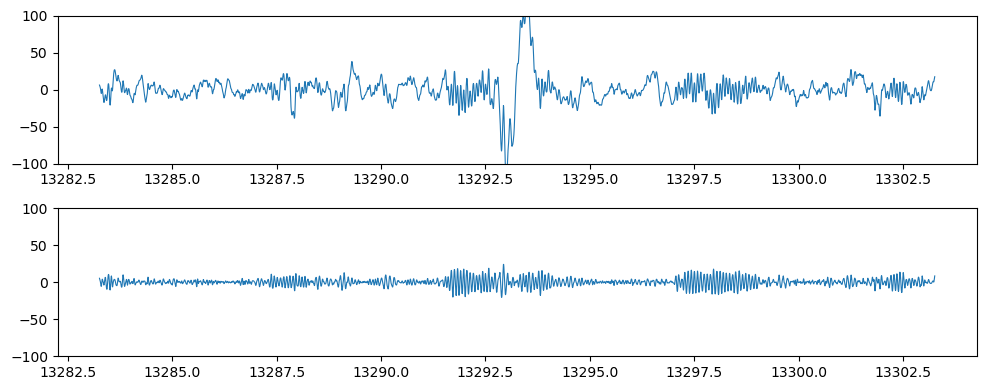

In [126]:
tf.reset_default_graph()
hp_signal_tf = highpass_tf(segment_signal, fs, cutoff=8, numtaps=375)
with tf.Session() as sess:
    hp_signal = sess.run(hp_signal_tf)

fig, ax = plt.subplots(2,1,figsize=(10, 4), dpi=100)
ax[0].plot(time_axis, segment_signal, linewidth=0.8)
ax[1].plot(time_axis, hp_signal, linewidth=0.8)
ax[0].set_ylim([-100, 100])
ax[1].set_ylim([-100, 100])
plt.tight_layout()
plt.show()

In [147]:
def alpha_augmentation_absolute_amplitude(signal, fs, abs_amp, page_size):
    alpha_wave_tf = generate_alpha_intrusion_tf(page_size, fs, alpha_max_amplitude=abs_amp)
    new_signal_tf = signal + alpha_wave_tf
    return new_signal_tf, alpha_wave_tf


def alpha_augmentation_relative_amplitude(signal, fs, rel_amp, page_size):
    hp_signal_tf = highpass_tf(signal, fs, cutoff=8, numtaps=375)
    alpha_max_amplitude = rel_amp * tf.reduce_max(hp_signal_tf)
    alpha_wave_tf = generate_alpha_intrusion_tf(page_size, fs, alpha_max_amplitude=alpha_max_amplitude)
    new_signal_tf = signal + alpha_wave_tf
    return new_signal_tf, alpha_wave_tf

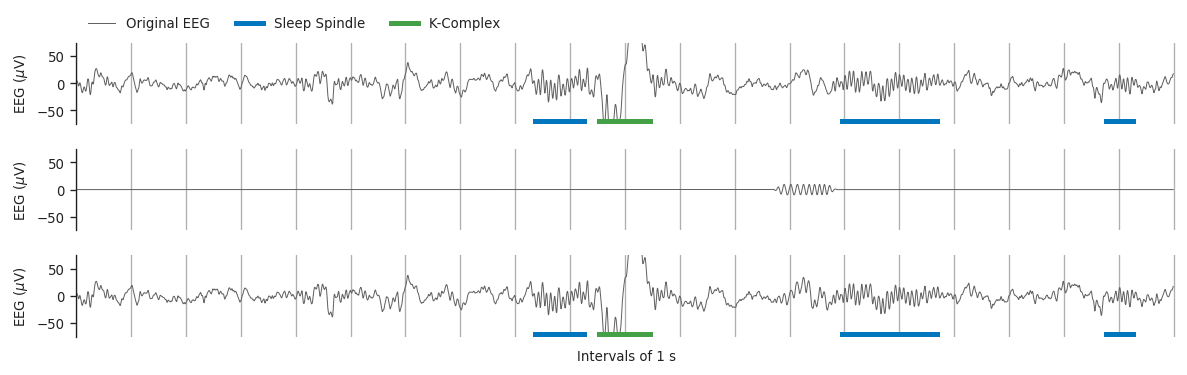

In [151]:
tf.reset_default_graph()
new_signal_tf, alpha_wave_tf = alpha_augmentation_relative_amplitude(segment_signal, fs, 0.7, dataset.page_size)
with tf.Session() as sess:
    new_signal, alpha_wave = sess.run([new_signal_tf, alpha_wave_tf])
    
fig, axes = plt.subplots(3, 1, dpi=120, figsize=(10, 3))
for ax_num, ax, this_signal, name in zip(
    range(3), axes, [segment_signal, alpha_wave, new_signal], ["Original EEG", "Synthetic Alpha Wave", "Modified EEG"]):
    ax.plot(time_axis, this_signal, linewidth=0.6, color=signal_color, label=name)
    stamp_label_used = False
    if ax_num != 1:
        for stamp in segment_stamps_ss:
            if stamp_label_used:
                label = None
            else:
                label = 'Sleep Spindle'
                stamp_label_used = True
            ax.plot(
                [stamp[0] / fs, stamp[1] / fs + ss_correction_right], [-70, -70], label=label, 
                color=ss_color, linewidth=linewidth_mark)
        stamp_label_used = False
        for stamp in segment_stamps_kc:
            if stamp_label_used:
                label = None
            else:
                label = 'K-Complex'
                stamp_label_used = True
            ax.plot(
                stamp / fs, [-70, -70], label=label, 
                color=kc_color, linewidth=linewidth_mark)
    ax.set_ylabel('EEG ($\mu$V)', fontsize=viz.FONTSIZE_GENERAL)
    ax.set_yticks([-50, 0, 50])
    ax.set_xlim([time_axis[0], time_axis[-1]+0.05])
    ax.set_ylim([-75, 75])
    ax.set_xticks([])
    ax.set_xticks(np.arange(time_axis[0], time_axis[-1]+0.1, 1), minor=True)
    ax.grid(b=True, axis='x', which='minor')
    ax.tick_params(labelsize=viz.FONTSIZE_GENERAL)
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.tick_params(axis='x', which='both',length=0)
    if ax_num == 0:
        lg = ax.legend(loc='lower left', bbox_to_anchor=(0,1), ncol=3, fontsize=viz.FONTSIZE_GENERAL, frameon=False)
        for lh in lg.legendHandles:
            lh.set_alpha(min(2 * alpha, 1.0))
        # Change color of plot
        plt.setp(lg.get_texts(), color=general_color)
    ax = plotter.set_axis_color(ax, general_color)
axes[-1].set_xlabel('Intervals of 1 s', fontsize=viz.FONTSIZE_GENERAL)
plt.tight_layout()
plt.show()